# TIAFI Monthly reporting

[TIAFI's](https://tiafi.org/) monthly reporting notebook aims to help an NGO supporting Syrian refugees in Izmir, Turkey to gather insights on the organization's information point service (providing information and assistance to those who struggle with the Turkish language and/or following government guidance). For the sake of the organization's external reporting requirements, the data is analysed from the 21st to the 20th of each month.

## 1) Clean data

### 1.1 Read-in data

In [1]:
# imports libraries
import pandas as pd
import numpy as np 

# reads in the data
people = pd.read_excel('C:/Users/HUAWEI/Desktop/Projects/TIAFI-Data-Analysis/people_data.xlsx')
cases = pd.read_excel('C:/Users/HUAWEI/Desktop/Projects/TIAFI-Data-Analysis/cases_data.xlsx')
support = pd.read_excel('C:/Users/HUAWEI/Desktop/Projects/TIAFI-Data-Analysis/support_data.xlsx')

# reates a dataframes object for iteration. 
dataframes = ['people', 'cases','support']

# defines how many previous months to include
show_dates = 8

### 1.2 Create start/end dates

In [2]:
# creates a list of unique months in datetime format and converts them to string format 
datetimes = people.iloc[:,0].astype("datetime64[M]").unique() # datetime format (from the 1st day)
string_months = [str(date).split('T')[0] for date in datetimes] # string format (from the 1st day)
string_months = string_months[0:show_dates+1] # reduces the dates to the number specificied in show_dates

# creates two lists of unique months starting on the 20th and 21st
start = ['-'.join(month.split('-')[0:2]) + '-21' for month in string_months] # (from the 21st day)
end = ['-'.join(month.split('-')[0:2]) + '-20' for month in string_months] # (from the 20th day)

# creates two lists of matching start and end month pairs
start_months = start[1:len(start)]
end_months = end[0:(len(end)-1)]

### 1.3 Create simple date labels

In [3]:
# reverses the start/end months with most recent last
start_months.reverse()
end_months.reverse()

# creates simplified date labels for plotting
labels = []
for i in range(len(end_months)):
    labels.append(str(end_months[i]).split('-')[1] + '-' + str(end_months[i]).split('-')[0][2:4])
    
# re-assigns start/end dates so that they can be used for numerical filtering
start_months = [''.join(date.split('-')) for date in start_months]
end_months = [''.join(date.split('-')) for date in end_months]

### 1.4 Re-format dataframe dates

In [4]:
# transforms dataframe dates so that they can be numerically filtered. 
def transform_dates(df):
    temp_dates = df['date'].astype("datetime64[D]")
    df['date'] = [str(date).split(' ')[0] for date in temp_dates]

for i in range(len(dataframes)): 
    transform_dates(eval(dataframes[i]))

## 2) Data Analysis

### 2.1 Calculate totals

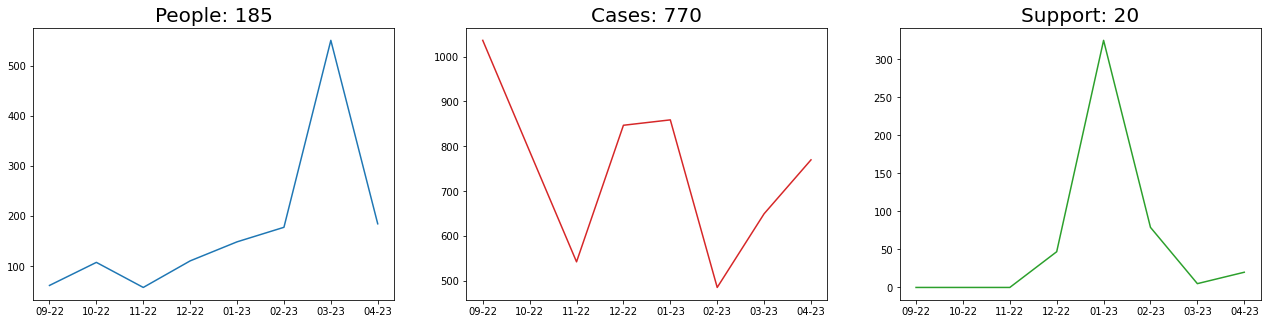

In [5]:
# plots the totals for people and cases
import matplotlib.pyplot as plt

# gets the totals for a given data frame
def get_totals(df):
    data = df
    totals = []
    for i in range(show_dates):
        data.reset_index(drop=True, inplace=True)
        data.date = [''.join(date.split('-')) for date in data.date]
        index = (len(start_months)-1)-i
        totals.append(sum([date >= start_months[index] and date <= end_months[index] for date in data.date]))
    totals.reverse()
    return totals

# creates a subplot
graph, (plot1, plot2, plot3) = plt.subplots(1, 3, figsize=(22, 5))

# creates a people plot
plot1.plot(labels, get_totals(people), color='tab:blue')
plot1.set_title('People: ' + str(get_totals(people)[show_dates-1]), size=20); 

# creates a cases plot
plot2.plot(labels, get_totals(cases), color='tab:red')
plot2.set_title('Cases: ' + str(get_totals(cases)[show_dates-1]), size=20); 

# creates a support plot
plot3.plot(labels, get_totals(support), color='tab:green')
plot3.set_title('Support: ' + str(get_totals(support)[show_dates-1]), size=20); 

### 2.2 Unique cases

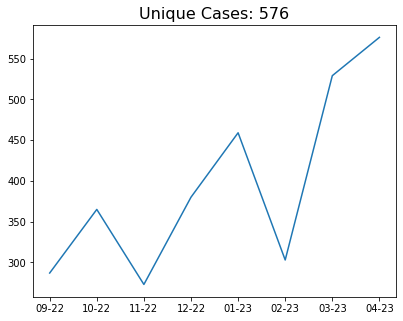

In [6]:
# plots the total for unique cases
def get_unique_cases(df):
    unique = []
    for i in range(len(start_months)):
        rows = [date > start_months[i] and date < end_months[i] for date in df.date]
        unique.append(len(df[rows].person_id.unique()))
    return unique

# creates a plot
graph, plot1 = plt.subplots(1, 1, figsize=(6.5, 5))

# creates a people plot
plot1.plot(labels[len(labels)-show_dates:len(labels)], get_unique_cases(cases)[len(labels)-show_dates:len(labels)], color='tab:blue')
plot1.set_title('Unique Cases: ' + str(get_unique_cases(cases)[len(start_months)-1]), size=16);

### 2.3 Solved cases

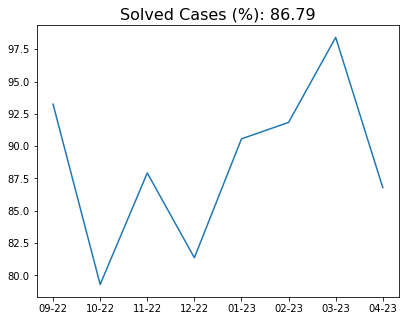

In [7]:
# plots the solved verses unsolved cases
def get_solved_cases(df):
    solved_percent = []
    for i in range(len(start_months)):
        rows = [date > start_months[i] and date < end_months[i] for date in df.date]
        solved = len([answer for answer in df[rows].solved if(answer in ['Yes', 'solved'])])
        solved_percent.append((solved / sum(rows))*100)
    return solved_percent

# creates a plot
graph, plot1 = plt.subplots(1, 1, figsize=(6.5, 5))

# creates a people plot
plot1.plot(labels[len(labels)-show_dates:len(labels)], get_solved_cases(cases)[len(labels)-show_dates:len(labels)],color='tab:blue')
plot1.set_title('Solved Cases (%): ' + str(round(get_solved_cases(cases)[len(start_months)-1],2)), size=16);

### 2.4 Top case reasons

In [8]:
# sets how many reasons to show
show_reasons = 5

# filters out a problematic case reason value
cases = cases.loc[cases.reason != 'Other']

# converts all strings to lower
cases.reason = cases.reason.str.lower()

# fixes a data input error
cases.loc[cases.quantity == "' -", 'quantity'] = '1'

cases = cases.assign(quantity = [eval(x) for x in cases.quantity])

# gets a dataframe of the current and last month's cases 
case_reason_dfs = []
for i in range(1,3):
    rows = [date >= start_months[len(start_months)-i] and date <= end_months[len(end_months)-i] for date in cases.date]
    case_reason_dfs.append(cases[rows].sort_values('date', axis=0, ascending=False))

# gets a grouped dataframe of this months case reasons by number
current_df = case_reason_dfs[0].groupby('reason').sum('quantity').sort_values('case_id', axis=0, ascending=False)

# prints a dataframe of the
pd.DataFrame({'Reason': list(current_df.index), 'Quantity': current_df.quantity}).reset_index(drop=True)

,Reason,Quantity
0,food package,491
1,asking for help,89
2,hospital appointment,71
3,hospital registration,23
4,general questıon,21
5,updating data,15
6,milk,9
7,daily food,8
8,travel permission,6
9,address confirmation,3


### 2.5 Case reason changes

In [87]:
# gets a grouped dataframe of this months case reasons by number
past_df = case_reason_dfs[1].groupby('reason').sum('quantity').sort_values('quantity', axis=0, ascending=False)

# sorts by reason
current_df = current_df.sort_values('reason')
past_df = past_df.sort_values('reason')

# creates indexs of matching reason present in both the current and previous month
current_matches = []
for i in range(len(current_df)):
    if current_df.index[i] in list(past_df.index):
        current_matches.append(i)         
past_matches = []
for i in range(len(past_df)):
    if past_df.index[i] in list(current_df.index):
        past_matches.append(i)
        
# filters each df for only matching case reasons
current_df = current_df.iloc[current_matches]
past_df = past_df.iloc[past_matches]

# loops through each reason to collect overall differences and percentage differences
difference = []
percentage = []
for i in range(len(current_df)):
    difference.append(current_df.quantity[i] - past_df.quantity[i])
    increase = current_df.quantity[i] - past_df.quantity[i]
    percentage.append(round((increase / past_df.quantity[i]) * 100))
    
# creates a combined dataframe of case reason differences and percentage changes
reason_difference_df = pd.DataFrame({'Reason': current_df.index, 'Difference': difference, 'Percent': percentage})

# prints out a table of the differences and percentage differences
reason_difference_df.sort_values('Difference', ascending=False)

,Reason,Difference,Percent
1,asking for help,85,2125
5,hospital appointment,24,51
4,general questıon,12,133
6,hospital registration,12,109
9,updating data,10,200
2,daily food,3,60
7,milk,2,29
8,travel permission,2,50
0,address confirmation,0,0
3,food package,-73,-13


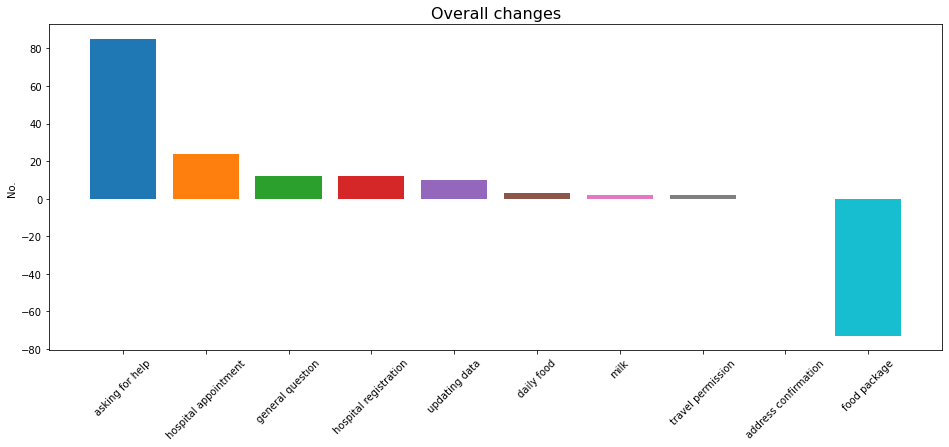

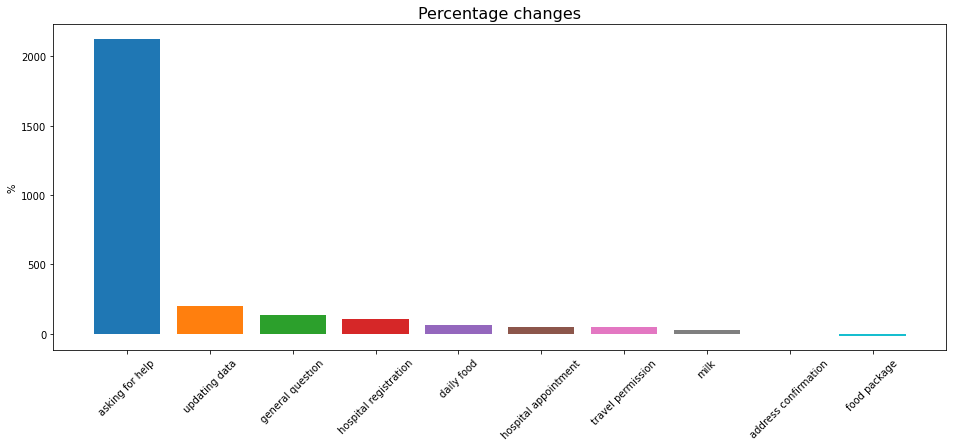

In [88]:
# creates two sorted dataframes for plotting
difference = reason_difference_df.sort_values('Difference', ascending=False)
percent = reason_difference_df.sort_values('Percent', ascending=False)

# specifies a list of colors for plotting - ADD MORE COLORS AS NEEDED
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'm']

# creates biggest percent decrease plot 
graph, plot1 = plt.subplots(1, 1, figsize=(16, 6))
plot1.bar(difference.Reason, height=difference.Difference, color=colors);
plot1.set_title('Overall changes', size=16);
plot1.set_ylabel('No.');
plot1.tick_params(axis='x', labelrotation=45);

# creates biggest percent decrease plot 
graph, plot1 = plt.subplots(1, 1, figsize=(16, 6))
plot1.bar(percent.Reason, height=percent.Percent, color=colors);
plot1.set_title('Percentage changes', size=16);
plot1.set_ylabel('%');
plot1.tick_params(axis='x', labelrotation=45);